In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import collections # For frequency counting
import findspark
findspark.init("/home/arpit/Downloads/spark2")

import pyspark
from pyspark.sql import DataFrameNaFunctions
from pyspark.sql.functions import lit # Create columns of *literal* value
from pyspark.sql.functions import col # Returns a Column based on the 
                                      # given column name
from pyspark.ml.feature import StringIndexer #label encoding
from pyspark.ml import Pipeline

sc = pyspark.SparkContext(appName="helloworld")

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
trainDF = spark.read.csv("/home/arpit/Downloads/spark_machine_learning_tutorial-master (3)/Hands-on_Activities/data/train.csv", header="true")
testDF = spark.read.csv("/home/arpit/Downloads/spark_machine_learning_tutorial-master (3)/Hands-on_Activities/data/test.csv", header="true")

In [4]:
trainDF.count()

891

**Combine train and test data.**

In [5]:
## Add Survived column to test, and dataset name as a column
trainDF = trainDF.withColumn('Mark', lit('train'))
testDF = (testDF.withColumn('Survived',lit(0))
                .withColumn('Mark', lit('test')))
testDF = testDF[trainDF.columns]

## Append Test data to Train data
df = trainDF.unionAll(testDF)

In [6]:
df.createOrReplaceTempView("train")

In [7]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Mark']

In [8]:
df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)



In [9]:
df.show(5)

+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked| Mark|
+-----------+--------+------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+-----+
|          1|       0|     3|Braund, Mr. Owen ...|  male| 22|    1|    0|       A/5 21171|   7.25|     |       S|train|
|          2|       1|     1|Cumings, Mrs. Joh...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|train|
|          3|       1|     3|Heikkinen, Miss. ...|female| 26|    0|    0|STON/O2. 3101282|  7.925|     |       S|train|
|          4|       1|     1|Futrelle, Mrs. Ja...|female| 35|    1|    0|          113803|   53.1| C123|       S|train|
|          5|       0|     3|Allen, Mr. Willia...|  male| 35|    0|    0|          373450|   8.05|     |       S|train|
+-----------+--------+------+-----------

In [10]:
# Here is an example
df = df.withColumn("AgeTmp", df["Age"].cast("float")) \
    .drop("Age") \
    .withColumnRenamed("AgeTmp", "Age")

In [11]:
# Let's define function
def to_anytype(df, colnames, typename):
    for colname in colnames:
        df = df.withColumn("tmp", df[colname].cast(typename)) \
        .drop(colname) \
        .withColumnRenamed("tmp", colname)
    return(df)

In [12]:
intCols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Survived']
floatCols = ['Age', 'Fare']

df = to_anytype(df, intCols, "integer")
df = to_anytype(df, floatCols, "float")

In [13]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Fare: float (nullable = true)



In [14]:
df.take(5)

[Row(Name=u'Braund, Mr. Owen Harris', Sex=u'male', Ticket=u'A/5 21171', Cabin=u'', Embarked=u'S', Mark=u'train', PassengerId=1, Pclass=3, SibSp=1, Parch=0, Survived=0, Age=22.0, Fare=7.25),
 Row(Name=u'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex=u'female', Ticket=u'PC 17599', Cabin=u'C85', Embarked=u'C', Mark=u'train', PassengerId=2, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=38.0, Fare=71.2833023071289),
 Row(Name=u'Heikkinen, Miss. Laina', Sex=u'female', Ticket=u'STON/O2. 3101282', Cabin=u'', Embarked=u'S', Mark=u'train', PassengerId=3, Pclass=3, SibSp=0, Parch=0, Survived=1, Age=26.0, Fare=7.925000190734863),
 Row(Name=u'Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex=u'female', Ticket=u'113803', Cabin=u'C123', Embarked=u'S', Mark=u'train', PassengerId=4, Pclass=1, SibSp=1, Parch=0, Survived=1, Age=35.0, Fare=53.099998474121094),
 Row(Name=u'Allen, Mr. William Henry', Sex=u'male', Ticket=u'373450', Cabin=u'', Embarked=u'S', Mark=u'train', PassengerId=5, Pclass=3, S

In [15]:
df.show(5)

+--------------------+------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+
|                Name|   Sex|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|
+--------------------+------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+
|Braund, Mr. Owen ...|  male|       A/5 21171|     |       S|train|          1|     3|    1|    0|       0|22.0|   7.25|
|Cumings, Mrs. Joh...|female|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|
|Heikkinen, Miss. ...|female|STON/O2. 3101282|     |       S|train|          3|     3|    0|    0|       1|26.0|  7.925|
|Futrelle, Mrs. Ja...|female|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|
|Allen, Mr. Willia...|  male|          373450|     |       S|train|          5|     3|    0|    0|       0|35.0|   8.05|
+--------------------+------+---

In [16]:
df.describe('Age').show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|              1046|
|   mean|29.881137667305726|
| stddev|14.413493211267733|
|    min|              0.17|
|    max|              80.0|
+-------+------------------+



In [17]:
df.describe(['Age', 'Name']).show()

+-------+------------------+--------------------+
|summary|               Age|                Name|
+-------+------------------+--------------------+
|  count|              1046|                1309|
|   mean|29.881137667305726|                null|
| stddev|14.413493211267733|                null|
|    min|              0.17|"Andersson, Mr. A...|
|    max|              80.0|van Melkebeke, Mr...|
+-------+------------------+--------------------+



In [18]:
df.describe(trainDF.columns).show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+-----+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|             Fare|Cabin|Embarked| Mark|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+-----+
|  count|             1309|               1309|              1309|                1309|  1309|              1046|              1309|              1309|              1309|             1308| 1309|    1309| 1309|
|   mean|            655.0| 0.2612681436210848| 2.294881588999236|                null|  null|29.881137667305726|0.4988540870893812|0.3850267379679144| 249039.1

In [19]:
df.describe(trainDF.columns[1:4]).show()

+-------+-------------------+------------------+--------------------+
|summary|           Survived|            Pclass|                Name|
+-------+-------------------+------------------+--------------------+
|  count|               1309|              1309|                1309|
|   mean| 0.2612681436210848| 2.294881588999236|                null|
| stddev|0.43949364010802755|0.8378360189701275|                null|
|    min|                  0|                 1|"Andersson, Mr. A...|
|    max|                  1|                 3|van Melkebeke, Mr...|
+-------+-------------------+------------------+--------------------+



In [20]:
df.describe(trainDF.columns[5:8]).show()

+-------+------------------+------------------+------------------+
|summary|               Age|             SibSp|             Parch|
+-------+------------------+------------------+------------------+
|  count|              1046|              1309|              1309|
|   mean|29.881137667305726|0.4988540870893812|0.3850267379679144|
| stddev|14.413493211267733|1.0416583905961019|0.8655602753495152|
|    min|              0.17|                 0|                 0|
|    max|              80.0|                 8|                 9|
+-------+------------------+------------------+------------------+



In [21]:
df.describe(trainDF.columns[9:12]).show()

+-------+-----------------+-----+--------+
|summary|             Fare|Cabin|Embarked|
+-------+-----------------+-----+--------+
|  count|             1308| 1309|    1309|
|   mean|33.29547938203228| null|    null|
| stddev|51.75866881037215| null|    null|
|    min|              0.0|     |        |
|    max|         512.3292|    T|       S|
+-------+-----------------+-----+--------+



In [22]:
age_hist = spark.sql(
    "SELECT Age AS age, \
            count(*) AS count \
    FROM train \
    GROUP BY Age \
    ORDER BY Age")
age_hist.show(n=age_hist.count())

+----+-----+
| age|count|
+----+-----+
|    |  263|
|0.17|    1|
|0.33|    1|
|0.42|    1|
|0.67|    1|
|0.75|    3|
|0.83|    3|
|0.92|    2|
|   1|   10|
|  10|    4|
|  11|    4|
|11.5|    1|
|  12|    3|
|  13|    5|
|  14|    8|
|14.5|    2|
|  15|    6|
|  16|   19|
|  17|   20|
|  18|   39|
|18.5|    3|
|  19|   29|
|   2|   12|
|  20|   23|
|20.5|    1|
|  21|   41|
|  22|   43|
|22.5|    1|
|  23|   26|
|23.5|    1|
|  24|   47|
|24.5|    1|
|  25|   34|
|  26|   30|
|26.5|    1|
|  27|   30|
|  28|   32|
|28.5|    3|
|  29|   30|
|   3|    7|
|  30|   40|
|30.5|    2|
|  31|   23|
|  32|   24|
|32.5|    4|
|  33|   21|
|  34|   16|
|34.5|    2|
|  35|   23|
|  36|   31|
|36.5|    2|
|  37|    9|
|  38|   14|
|38.5|    1|
|  39|   20|
|   4|   10|
|  40|   18|
|40.5|    3|
|  41|   11|
|  42|   18|
|  43|    9|
|  44|   10|
|  45|   21|
|45.5|    2|
|  46|    6|
|  47|   14|
|  48|   14|
|  49|    9|
|   5|    5|
|  50|   15|
|  51|    8|
|  52|    6|
|  53|    4|
|  54|   10|

In [23]:
age_hist = spark.sql(
    "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(Age/5.00)*5 as bucket_floor, \
            floor(Age/5.00)*5 + 5 as bucket_ceiling \
        FROM train \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1")

age_hist.show(n=age_hist.count())


+------------+-----------+-----+
|bucket_floor|bucket_name|count|
+------------+-----------+-----+
|        null|       null|  263|
|           0|     0 to 5|   51|
|           5|    5 to 10|   31|
|          10|   10 to 15|   27|
|          15|   15 to 20|  116|
|          20|   20 to 25|  184|
|          25|   25 to 30|  160|
|          30|   30 to 35|  132|
|          35|   35 to 40|  100|
|          40|   40 to 45|   69|
|          45|   45 to 50|   66|
|          50|   50 to 55|   43|
|          55|   55 to 60|   27|
|          60|   60 to 65|   27|
|          65|   65 to 70|    5|
|          70|   70 to 75|    6|
|          75|   75 to 80|    1|
|          80|   80 to 85|    1|
+------------+-----------+-----+



In [24]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

age = get_column(age_hist, "bucket_name")
count = get_column(age_hist, "count")

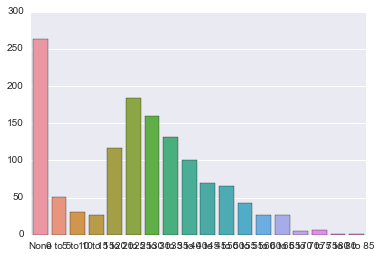

In [27]:
%matplotlib inline

barplt = sns.barplot(age, count)

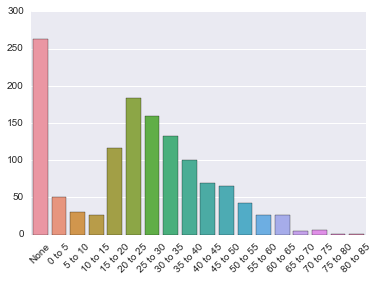

In [26]:
%matplotlib inline

barplt = sns.barplot(age, count)
for item in barplt.get_xticklabels():
    item.set_rotation(45)

In [27]:
def get_column(df, colname):
    coldata = df.rdd.map(lambda r: r[colname]).collect()
    coldata = ['None' if v is None else v for v in coldata] #replace None values
    return(coldata)

def histplot(dfname, colname, binsize):
    binsize = str(binsize)
    dfname.createOrReplaceTempView("tmpDF")
    hist_query = "SELECT bucket_floor, \
        CONCAT(bucket_floor, ' to ', bucket_ceiling) as bucket_name, \
        count(*) as count \
     FROM ( \
        SELECT floor(" + colname + "/" + binsize + ")*" + binsize + " as bucket_floor, \
            floor(" + colname + "/" + binsize + ")*" + binsize + " + " + binsize + " as bucket_ceiling \
        FROM tmpDF \
     ) a \
     GROUP BY 1, 2 \
     ORDER BY 1"
    hist_data = spark.sql(hist_query)
    xvar = get_column(hist_data, "bucket_name")
    count = get_column(hist_data, "count")
    barplt = sns.barplot(xvar, count)
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

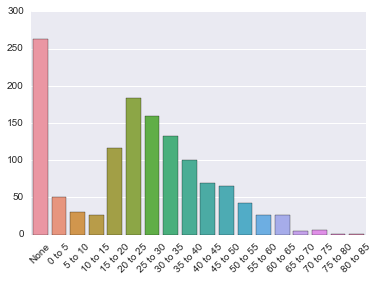

In [30]:
histplot(df, "Age", 5)

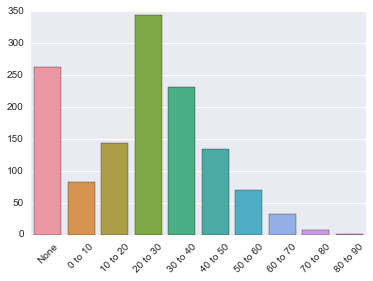

In [31]:
histplot(df, "Age", 10)

In [32]:
df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Mark: string (nullable = false)
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Age: float (nullable = true)
 |-- Fare: float (nullable = true)



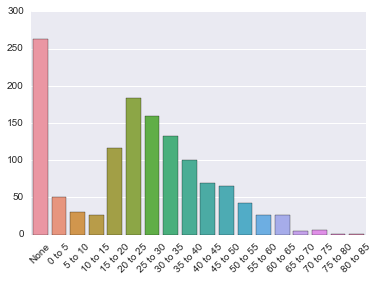

In [33]:
histplot(df, "Age", 5)

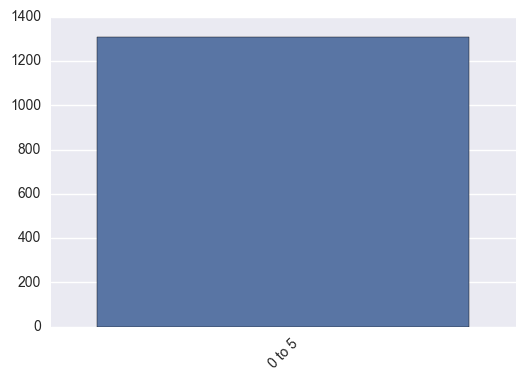

In [36]:
histplot(df, "Survived", 5)

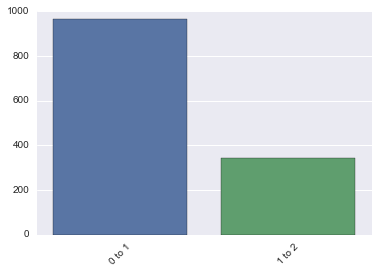

In [34]:
histplot(df, "Survived", 1)

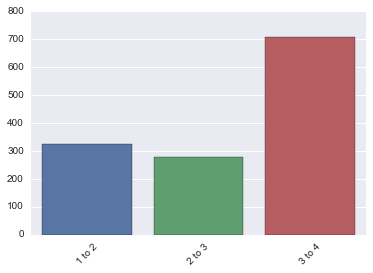

In [35]:
histplot(df, "Pclass", 1)

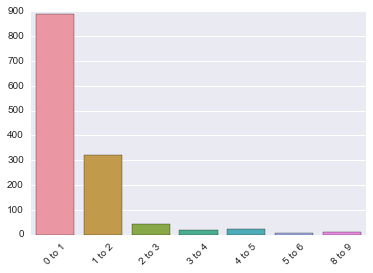

In [37]:
histplot(df, "SibSp", 1)

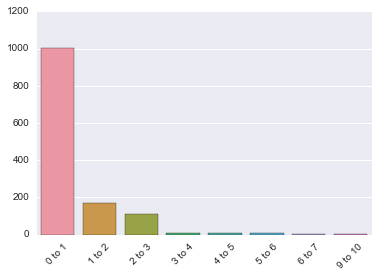

In [38]:
histplot(df, "Parch", 1)

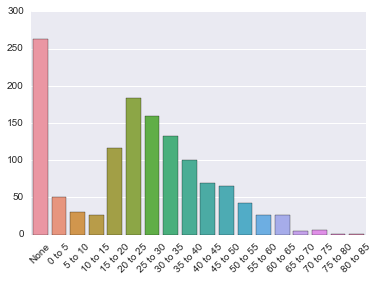

In [39]:
histplot(df, "Age", 5)

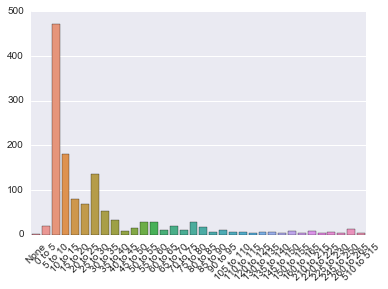

In [40]:
histplot(df, "Fare", 5)

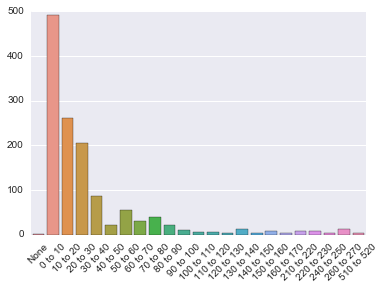

In [41]:
histplot(df, "Fare", 10)

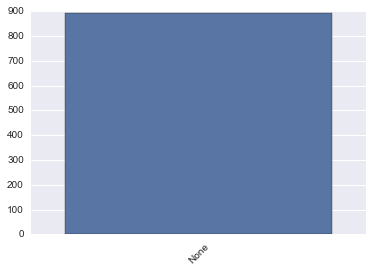

In [28]:
histplot(trainDF, "Embarked", 1)

In [29]:
def histplot_s(df, colname):
    xvar = get_column(df, colname)
    counter = collections.Counter(xvar)
    barplt = sns.barplot(list(counter.keys()), list(counter.values()))
    for item in barplt.get_xticklabels():
        item.set_rotation(45)
    return(barplt)

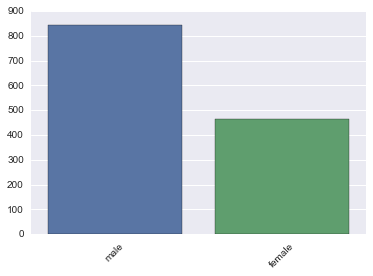

In [30]:
histplot_s(df, "Sex")

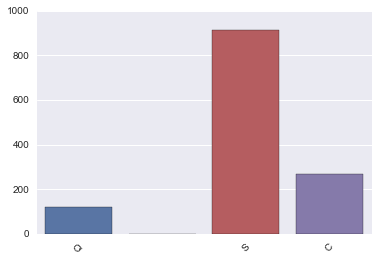

In [31]:
histplot_s(df, "Embarked")

#### Correlations

In [32]:
df.corr("Age", "Fare")

0.21349686667435705

In [33]:
df.corr("Age", "Survived")

0.005296468730662016

In [34]:
df.corr("Fare", "Survived")

0.1738945206553876

In [45]:
numVars = ['Survived','Age','SibSp','Parch']
stringVars = ['Cabin', 'Embarked', 'Pclass', 'Sex']

def countNull(df,var):
    return df.where(df[var].isNull()).count()

def countEmptyString(df,var):
    return df[df[var].isin("")].count()

def countZero(df,var):
    return df[df[var].isin(0)].count()

In [50]:
missing = {var: countNull(df,var) for var in df.columns}
missing

{'Age': 263,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 1,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [51]:
missing = {var: countEmptyString(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 1014,
 'Embarked': 2,
 'Fare': 0,
 'Mark': 0,
 'Name': 0,
 'Parch': 0,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 0,
 'Survived': 0,
 'Ticket': 0}

In [54]:
missing = {var: countZero(df, var) for var in df.columns}
missing

{'Age': 0,
 'Cabin': 0,
 'Embarked': 0,
 'Fare': 17,
 'Mark': 0,
 'Name': 0,
 'Parch': 1002,
 'PassengerId': 0,
 'Pclass': 0,
 'Sex': 0,
 'SibSp': 891,
 'Survived': 967,
 'Ticket': 0}

In [52]:
age_mean = df.groupBy().mean('Age').first()
age_mean

Row(avg(Age)=29.881137667305726)

In [53]:
age_mean[0]

29.881137667305726

In [203]:
age_mean = df.groupBy().mean('Age').first()[0]
fare_mean = df.groupBy().mean('Fare').first()[0]
age_mean, fare_mean

(29.881137703590216, 33.295479381603535)

In [46]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
 
## create user defined function to extract title
getTitle = udf(lambda name: name.split('.')[0].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+---------------+
|                Name|          Title|
+--------------------+---------------+
|Braund, Mr. Owen ...|     Braund, Mr|
|Cumings, Mrs. Joh...|   Cumings, Mrs|
|Heikkinen, Miss. ...|Heikkinen, Miss|
|Futrelle, Mrs. Ja...|  Futrelle, Mrs|
|Allen, Mr. Willia...|      Allen, Mr|
+--------------------+---------------+
only showing top 5 rows



In [47]:
getTitle = udf(lambda name: name.split('.')[0].split(',')[1].strip(), StringType())
df = df.withColumn('Title', getTitle(df['Name']))
 
df.select('Name','Title').show(5)

+--------------------+-----+
|                Name|Title|
+--------------------+-----+
|Braund, Mr. Owen ...|   Mr|
|Cumings, Mrs. Joh...|  Mrs|
|Heikkinen, Miss. ...| Miss|
|Futrelle, Mrs. Ja...|  Mrs|
|Allen, Mr. Willia...|   Mr|
+--------------------+-----+
only showing top 5 rows



In [48]:
catVars = ['Pclass','Sex','Embarked','Title']
 
## index Sex variable
si = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
df_indexed = si.fit(df).transform(df).drop('Sex').withColumnRenamed('Sex_indexed','Sex')

In [49]:
df_indexed.show(5)

+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|                Name|          Ticket|Cabin|Embarked| Mark|PassengerId|Pclass|SibSp|Parch|Survived| Age|   Fare|Title|Sex|
+--------------------+----------------+-----+--------+-----+-----------+------+-----+-----+--------+----+-------+-----+---+
|Braund, Mr. Owen ...|       A/5 21171|     |       S|train|          1|     3|    1|    0|       0|22.0|   7.25|   Mr|0.0|
|Cumings, Mrs. Joh...|        PC 17599|  C85|       C|train|          2|     1|    1|    0|       1|38.0|71.2833|  Mrs|1.0|
|Heikkinen, Miss. ...|STON/O2. 3101282|     |       S|train|          3|     3|    0|    0|       1|26.0|  7.925| Miss|1.0|
|Futrelle, Mrs. Ja...|          113803| C123|       S|train|          4|     1|    1|    0|       1|35.0|   53.1|  Mrs|1.0|
|Allen, Mr. Willia...|          373450|     |       S|train|          5|     3|    0|    0|       0|35.0|   8.05|   Mr|0.0|
+-------

In [50]:
# make use of pipeline to index all categorical variables
def indexer(df, col):
    si = StringIndexer(inputCol = col, outputCol = col+'_indexed').fit(df)
    return si
 
indexers = [indexer(df, col) for col in catVars]

In [51]:
pipeline = Pipeline(stages = indexers)
df_indexed = pipeline.fit(df).transform(df)
 
df_indexed.select('Embarked','Embarked_indexed').show(3)

+--------+----------------+
|Embarked|Embarked_indexed|
+--------+----------------+
|       S|             0.0|
|       C|             1.0|
|       S|             0.0|
+--------+----------------+
only showing top 3 rows



In [52]:
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

In [53]:
catVarsIndexed = [i + '_indexed' for i in catVars]
catVarsIndexed

['Pclass_indexed', 'Sex_indexed', 'Embarked_indexed', 'Title_indexed']

In [54]:
featuresCol = numVars + catVarsIndexed
featuresCol

['Survived',
 'Age',
 'SibSp',
 'Parch',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [55]:
featuresCol.remove('Survived')
featuresCol

['Age',
 'SibSp',
 'Parch',
 'Pclass_indexed',
 'Sex_indexed',
 'Embarked_indexed',
 'Title_indexed']

In [56]:
labelCol = ['Mark','Survived']
labelCol

['Mark', 'Survived']

In [57]:
row = Row('mark','label','features') 
row

<Row(mark, label, features)>

In [58]:
df_indexed = df_indexed[labelCol + featuresCol]
df_indexed

DataFrame[Mark: string, Survived: int, Age: float, SibSp: int, Parch: int, Pclass_indexed: double, Sex_indexed: double, Embarked_indexed: double, Title_indexed: double]

In [59]:
# 0-mark, 1-label, 2-features
# map features to DenseVector
lf = df_indexed.rdd.map(lambda r: (row(r[0], r[1],DenseVector(r[2:])))).toDF()
lf.show()

+-----+-----+--------------------+
| mark|label|            features|
+-----+-----+--------------------+
|train|    0|[22.0,1.0,0.0,0.0...|
|train|    1|[38.0,1.0,0.0,1.0...|
|train|    1|[26.0,0.0,0.0,0.0...|
|train|    1|[35.0,1.0,0.0,1.0...|
|train|    0|[35.0,0.0,0.0,0.0...|
|train|    0|[NaN,0.0,0.0,0.0,...|
|train|    0|[54.0,0.0,0.0,1.0...|
|train|    0|[2.0,3.0,1.0,0.0,...|
|train|    1|[27.0,0.0,2.0,0.0...|
|train|    1|[14.0,1.0,0.0,2.0...|
|train|    1|[4.0,1.0,1.0,0.0,...|
|train|    1|[58.0,0.0,0.0,1.0...|
|train|    0|[20.0,0.0,0.0,0.0...|
|train|    0|[39.0,1.0,5.0,0.0...|
|train|    0|[14.0,0.0,0.0,0.0...|
|train|    1|[55.0,0.0,0.0,2.0...|
|train|    0|[2.0,4.0,1.0,0.0,...|
|train|    1|[NaN,0.0,0.0,2.0,...|
|train|    0|[31.0,1.0,0.0,0.0...|
|train|    1|[NaN,0.0,0.0,0.0,...|
+-----+-----+--------------------+
only showing top 20 rows



In [60]:
# index label
# convert numeric label to categorical, which is required by
# decisionTree and randomForest
lf = StringIndexer(inputCol = 'label', outputCol='index').fit(lf).transform(lf)
 
lf.show(3)

+-----+-----+--------------------+-----+
| mark|label|            features|index|
+-----+-----+--------------------+-----+
|train|    0|[22.0,1.0,0.0,0.0...|  0.0|
|train|    1|[38.0,1.0,0.0,1.0...|  1.0|
|train|    1|[26.0,0.0,0.0,0.0...|  1.0|
+-----+-----+--------------------+-----+
only showing top 3 rows



In [61]:
train = lf.where(lf.mark =='train')
test = lf.where(lf.mark =='test')

In [62]:
test.show(5)

+----+-----+--------------------+-----+
|mark|label|            features|index|
+----+-----+--------------------+-----+
|test|    0|[34.5,0.0,0.0,0.0...|  0.0|
|test|    0|[47.0,1.0,0.0,0.0...|  0.0|
|test|    0|[62.0,0.0,0.0,2.0...|  0.0|
|test|    0|[27.0,0.0,0.0,0.0...|  0.0|
|test|    0|[22.0,1.0,1.0,0.0...|  0.0|
+----+-----+--------------------+-----+
only showing top 5 rows



In [63]:
# random split further to get train/validate
train, validate = train.randomSplit([0.7,0.3], seed =121)

In [64]:
print('Train Data Number of Row: '+ str(train.count()))
print('Validate Data Number of Row: '+ str(validate.count()))
print('Test Data Number of Row: '+ str(test.count()))

Train Data Number of Row: 637
Validate Data Number of Row: 254
Test Data Number of Row: 418


In [65]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
 
dt = DecisionTreeClassifier(maxDepth = 3, labelCol ='index').fit(train)
rf = RandomForestClassifier(numTrees = 100, labelCol = 'index').fit(train)
gbt = GBTClassifier(maxIter = 10, labelCol = 'index').fit(train)


In [68]:
model= rf.transform(test)

In [69]:
model.show(40)


+----+-----+--------------------+-----+--------------------+--------------------+----------+
|mark|label|            features|index|       rawPrediction|         probability|prediction|
+----+-----+--------------------+-----+--------------------+--------------------+----------+
|test|    0|[34.5,0.0,0.0,0.0...|  0.0|[87.6090372116384...|[0.87609037211638...|       0.0|
|test|    0|[47.0,1.0,0.0,0.0...|  0.0|[58.4066940978952...|[0.58406694097895...|       0.0|
|test|    0|[62.0,0.0,0.0,2.0...|  0.0|[80.6159933881352...|[0.80615993388135...|       0.0|
|test|    0|[27.0,0.0,0.0,0.0...|  0.0|[85.0393325939633...|[0.85039332593963...|       0.0|
|test|    0|[22.0,1.0,1.0,0.0...|  0.0|[54.5398759562138...|[0.54539875956213...|       0.0|
|test|    0|[14.0,0.0,0.0,0.0...|  0.0|[87.8874269341946...|[0.87887426934194...|       0.0|
|test|    0|[30.0,0.0,0.0,0.0...|  0.0|[40.7476585539638...|[0.40747658553963...|       1.0|
|test|    0|[26.0,1.0,1.0,2.0...|  0.0|[88.6830072631517...|[0.8868300

In [71]:
model.write.csv('submission.csv')